In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap==0.45.0
!pip install torch==1.9.1
!pip install torchvision==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0
ERROR: Could not find a version that satisfies the requirement torch==1.9.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==1.9.1
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.1 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes, incluyendo la eliminación de transparencia
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ColorJitter(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from torchvision.models import inception_v3, Inception_V3_Weights

def prepare_model(num_classes, pretrained=True):
    if pretrained:
        # Specify the weights for the pretrained model
        weights = Inception_V3_Weights.IMAGENET1K_V1
    else:
        # If not using pretrained weights, set to None
        weights = None

    # Initialize the model with the specified weights
    model = inception_v3(weights=weights, aux_logits=True)

    # Replace the fully connected layer to match the number of classes in your dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    return model.to(device)

# Preparar optimizador y función de pérdida
def prepare_optimizer_and_loss(model, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    return optimizer, loss_fn

# Scheduler para ajustar el learning rate
def prepare_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    return scheduler

# Función básica de entrenamiento
def train_model(model, dataloaders, optimizer, loss_fn, scheduler, num_epochs=25):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs, aux_outputs = model(images)
            loss1 = loss_fn(outputs, labels)
            loss2 = loss_fn(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Combine losses

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        scheduler.step()  # Adjust the learning rate




In [4]:
def calculate_specificity(y_true, y_pred, labels):
    # Calculate specificity for each class
    specificity_list = []
    for label in labels:
        # All classes except the current are considered the negative class
        not_label_mask = y_true != label
        tn = np.sum((y_pred[not_label_mask] != label) & (y_true[not_label_mask] != label))
        fp = np.sum((y_pred[not_label_mask] == label) & (y_true[not_label_mask] != label))
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return np.mean(specificity_list)  # Return the average specificity


In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix


este si sirve

In [6]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
#from scipy import interp
from itertools import cycle


In [7]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def train_and_validate_model(model, train_loader, validation_loader, optimizer, loss_fn, epochs=25, fold_idx=1, device='cuda'):
    best_val_loss = float('inf')
    n_classes = 3
    metrics_per_fold = {
        'precision': [],
        'recall': [],
        'f1_score': [],
        'specificity': [],
        'cohen_kappa': [],
        'accuracy': [],
        'train_loss': [],
        'val_loss': [],
        'confusion_matrix': None,
        'roc_auc_micro': [],
        'roc_auc_macro': [],
        'fpr_micro': [],  # Initialize storage for micro-average FPR
        'tpr_micro': [],  # Initialize storage for micro-average TPR
        'fpr_macro': [],  # Initialize storage for macro-average FPR
        'tpr_macro': [],  # Initialize storage for macro-average TPR
        **{f'fpr_class_{i}': [] for i in range(n_classes)},
        **{f'tpr_class_{i}': [] for i in range(n_classes)},
        **{f'roc_auc_class_{i}': [] for i in range(n_classes)}
    }
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            model_output = model(images)
            outputs = model_output[0] if isinstance(model_output, tuple) else model_output
            loss = loss_fn(outputs, labels)
            if isinstance(model_output, tuple):
                aux_outputs = model_output[1]
                loss += 0.4 * loss_fn(aux_outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        model.eval()
        total_val_loss, all_preds, all_labels, all_probs = 0, [], [], []
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                model_output = model(images)
                outputs = model_output[0] if isinstance(model_output, tuple) else model_output
                val_loss = loss_fn(outputs, labels)
                if isinstance(model_output, tuple):
                    aux_outputs = model_output[1]
                    val_loss += 0.4 * loss_fn(aux_outputs, labels)
                total_val_loss += val_loss.item()
                preds = outputs.argmax(dim=1)
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(validation_loader)
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        accuracy = accuracy_score(all_labels, all_preds)
        kappa = cohen_kappa_score(all_labels, all_preds)
        specificity = calculate_specificity(all_labels, all_preds, np.unique(all_labels))
        cm = confusion_matrix(all_labels, all_preds)

        # Binarize the labels for ROC calculation
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        if all_labels_bin.shape[1] == 1:
            all_labels_bin = np.append(1 - all_labels_bin, all_labels_bin, axis=1)

        # ROC curve calculations...
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

        # Update metrics_per_fold with epoch metrics
        metrics_per_fold['precision'].append(precision)
        metrics_per_fold['recall'].append(recall)
        metrics_per_fold['f1_score'].append(f1)
        metrics_per_fold['specificity'].append(specificity)
        metrics_per_fold['cohen_kappa'].append(kappa)
        metrics_per_fold['accuracy'].append(accuracy)
        metrics_per_fold['train_loss'].append(avg_train_loss)
        metrics_per_fold['val_loss'].append(avg_val_loss)
        metrics_per_fold['confusion_matrix'] = cm
        metrics_per_fold['roc_auc_micro'].append(roc_auc["micro"])
        metrics_per_fold['roc_auc_macro'].append(roc_auc["macro"])

        # Save FPR and TPR for micro and macro averages
        metrics_per_fold['fpr_micro'].append(fpr["micro"])
        metrics_per_fold['tpr_micro'].append(tpr["micro"])
        metrics_per_fold['fpr_macro'].append(fpr["macro"])
        metrics_per_fold['tpr_macro'].append(tpr["macro"])

        # Update class-specific ROC metrics
        for i in range(n_classes):
            metrics_per_fold[f'fpr_class_{i}'].append(fpr[i])
            metrics_per_fold[f'tpr_class_{i}'].append(tpr[i])
            metrics_per_fold[f'roc_auc_class_{i}'].append(roc_auc[i])

        print(f'Fold {fold_idx}, Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1: {f1:.4f}, Specificity: {specificity:.4f}, '
              f'Kappa: {kappa:.4f}, Accuracy: {accuracy:.4f}, '
              f'Micro AUC: {roc_auc["micro"]:.4f}, Macro AUC: {roc_auc["macro"]:.4f}')
        print(f'Confusion Matrix:\n{cm}')

        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_model_fold_{fold_idx}.pth')

    return metrics_per_fold


In [8]:
# Function to create dataloaders for k-fold cross-validation
def load_data_for_cross_validation(directory, k_folds=5, batch_size=32):
    # Load the entire dataset
    dataset = ImageFolder(root=directory, transform=transform)

    # Creating indices for the entire dataset and splitting them into k folds
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split = int(np.floor(dataset_size/k_folds))

    # Dataloaders for each fold
    dataloaders = []

    for fold in range(k_folds):
        train_indices = indices[:fold * split] + indices[(fold + 1) * split:]
        val_indices = indices[fold * split:(fold + 1) * split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

        dataloaders.append((train_loader, validation_loader))

    return dataloaders


In [9]:
import numpy as np

def safe_mean(arrays):
    """Attempt to calculate the mean of arrays, even if they are of different lengths."""
    try:
        return np.mean(arrays)
    except ValueError:
        # Handle arrays of different shapes by returning None or some other placeholder value
        return None

def mean_of_metrics(all_fold_metrics):
    mean_metrics = {}
    for metric in all_fold_metrics[0].keys():
        metric_values = [fold_metrics[metric] for fold_metrics in all_fold_metrics]

        if isinstance(metric_values[0], (int, float, np.number)):
            mean_metrics[metric] = np.mean(metric_values)
        elif isinstance(metric_values[0], list):
            mean_metrics[metric] = [safe_mean([metric_values[fold][epoch] if epoch < len(metric_values[fold]) else np.nan
                                               for fold in range(len(all_fold_metrics))])
                                    for epoch in range(max(len(l) for l in metric_values))]
        elif isinstance(metric_values[0], dict):
            mean_dict = {}
            for key in metric_values[0].keys():
                # Collect all lists for this key across folds, handling variable lengths
                lists_for_key = [fold_metrics[key] for fold_metrics in metric_values if key in fold_metrics]
                max_length = max(len(l) for l in lists_for_key) if lists_for_key else 0
                mean_dict[key] = [safe_mean([l[epoch] if epoch < len(l) else np.nan for l in lists_for_key])
                                  for epoch in range(max_length)]
            mean_metrics[metric] = mean_dict
        else:
            print(f"Metric '{metric}' has an unsupported type and will be skipped.")

    return mean_metrics


modify for kfolds and epochs

In [10]:
import shutil
import os

# Ruta de la carpeta a eliminar
folder_path = '/content/descomprimido'

# Verificar si la carpeta existe
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Elimina la carpeta y su contenido
    print(f"La carpeta '{folder_path}' ha sido eliminada correctamente.")
else:
    print(f"La carpeta '{folder_path}' no existe.")


La carpeta '/content/descomprimido' no existe.


In [11]:
import zipfile
# Ruta del archivo ZIP que deseas descomprimir en Google Drive
ruta_zip = '/content/Hojascompleto-20241217T075343Z-001.zip'
# Ruta de la carpeta donde deseas extraer los archivos
ruta_destino = '/content/descomprimido/'  # Cambia esta ruta según tus preferencias

# Descomprimir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
    archivo_zip.extractall(ruta_destino)

In [12]:
# Set up the directory and parameters
directory =  "/content/descomprimido/Hojascompleto"#'/content/drive/MyDrive/papertaro/Hojascompleto'
k_folds = 5
batch_size = 32
num_classes = 3  # Number of classes in the dataset
num_epochs = 20  # Number of epochs to train for each fold

# Load the data for cross-validation
dataloaders = load_data_for_cross_validation(directory, k_folds=k_folds, batch_size=batch_size)
dataloaders

[(<torch.utils.data.dataloader.DataLoader at 0x7ac3237fee30>,
  <torch.utils.data.dataloader.DataLoader at 0x7ac3237fd570>),
 (<torch.utils.data.dataloader.DataLoader at 0x7ac3237fefe0>,
  <torch.utils.data.dataloader.DataLoader at 0x7ac3237fc0a0>),
 (<torch.utils.data.dataloader.DataLoader at 0x7ac3237fc0d0>,
  <torch.utils.data.dataloader.DataLoader at 0x7ac3237ff310>),
 (<torch.utils.data.dataloader.DataLoader at 0x7ac3237ff400>,
  <torch.utils.data.dataloader.DataLoader at 0x7ac3237ff430>),
 (<torch.utils.data.dataloader.DataLoader at 0x7ac3237fd540>,
  <torch.utils.data.dataloader.DataLoader at 0x7ac3237ff160>)]

In [13]:

# Variable to store metrics for each fold
all_fold_metrics = []

# Perform k-fold cross-validation
for fold_index, (train_loader, validation_loader) in enumerate(dataloaders, 1):
    print(f'Starting Fold {fold_index}')

    # Re-initialize the model for each fold
    model = prepare_model(num_classes, pretrained=True).to(device)
    optimizer, loss_fn = prepare_optimizer_and_loss(model)

    # Train and validate the model for the current fold
    fold_metrics = train_and_validate_model(
        model,
        train_loader,
        validation_loader,
        optimizer,
        loss_fn,
        epochs=num_epochs,
        fold_idx=fold_index
    )

    # Store the metrics
    all_fold_metrics.append(fold_metrics)

# Example usage:
mean_metrics = mean_of_metrics(all_fold_metrics)
print(f'Average metrics across all folds: {mean_metrics}')


Starting Fold 1


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 176MB/s]


Fold 1, Epoch [1/20], Train Loss: 0.1858, Val Loss: 0.1975, Precision: 0.9460, Recall: 0.9574, F1: 0.9512, Specificity: 0.9776, Kappa: 0.9275, Accuracy: 0.9539, Micro AUC: 0.9880, Macro AUC: 0.9849
Confusion Matrix:
[[ 76   2   0]
 [  7 142   1]
 [  0   9 175]]
Fold 1, Epoch [2/20], Train Loss: 0.1391, Val Loss: 0.6328, Precision: 0.8140, Recall: 0.8454, F1: 0.8141, Specificity: 0.9131, Kappa: 0.7243, Accuracy: 0.8204, Micro AUC: 0.9523, Macro AUC: 0.9671
Confusion Matrix:
[[ 76   2   0]
 [ 14 112  24]
 [ 29   5 150]]
Fold 1, Epoch [3/20], Train Loss: 0.0846, Val Loss: 0.0367, Precision: 0.9895, Recall: 0.9946, F1: 0.9919, Specificity: 0.9967, Kappa: 0.9885, Accuracy: 0.9927, Micro AUC: 0.9997, Macro AUC: 1.0000
Confusion Matrix:
[[ 78   0   0]
 [  0 150   0]
 [  2   1 181]]
Fold 1, Epoch [4/20], Train Loss: 0.0884, Val Loss: 0.1207, Precision: 0.9668, Recall: 0.9829, F1: 0.9739, Specificity: 0.9907, Kappa: 0.9657, Accuracy: 0.9782, Micro AUC: 0.9956, Macro AUC: 0.9992
Confusion Matrix

In [14]:
# Initialize a list to hold the last epoch metrics for each fold
last_epoch_metrics_for_each_fold = []

# Loop through each fold's metrics
for fold_metrics in all_fold_metrics:
    # Extract the last epoch metrics for the current fold
    last_epoch_metrics = {metric_name: metric_values[-1] for metric_name, metric_values in fold_metrics.items()}
    # Add the extracted metrics to the list
    last_epoch_metrics_for_each_fold.append(last_epoch_metrics)

# Now, last_epoch_metrics_for_each_fold contains the last epoch metrics for each fold
# If you need to print or further process these, you can iterate over the list
for i, metrics in enumerate(last_epoch_metrics_for_each_fold, start=1):
    print(f"Fold {i} last epoch metrics: {metrics}")


Fold 1 last epoch metrics: {'precision': 0.9934640522875817, 'recall': 0.9921033073206985, 'f1_score': 0.9927276387078159, 'specificity': 0.9961832061068702, 'cohen_kappa': 0.9884808946877912, 'accuracy': 0.9927184466019418, 'train_loss': 0.006744823818735313, 'val_loss': 0.05090007996393699, 'confusion_matrix': array([  0,   2, 182]), 'roc_auc_micro': 0.9990220567442738, 'roc_auc_macro': 0.9996821764556318, 'fpr_micro': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00121359, 0.00121359, 0.00242718, 0.00242718,
       0.00364078, 0.00364078, 0.00606796, 0.00606796, 0.08737864,
       0.08737864, 0.16868932, 0.16868932, 1.        ]), 'tpr_micro': array([0.        , 0.34466019, 0.412

In [15]:
# Assuming all_fold_metrics is a list of dictionaries, with each dictionary containing metrics for a fold
interested_metrics = ['precision', 'recall', 'f1_score', 'specificity', 'cohen_kappa', 'accuracy', 'roc_auc_micro', 'roc_auc_macro']

# Process each fold's metrics
for fold_index, fold_metrics in enumerate(all_fold_metrics, start=1):
    # Extract the last epoch's values for the interested metrics for the current fold
    last_epoch_values = {metric: fold_metrics[metric][-1] for metric in interested_metrics}

    # Display the fold number and the extracted values
    print(f"Fold {fold_index} last epoch metrics:")
    for metric, value in last_epoch_values.items():
        print(f"  {metric.capitalize()}: {value:.4f}")
    print()  # Add a blank line for better separation between folds


Fold 1 last epoch metrics:
  Precision: 0.9935
  Recall: 0.9921
  F1_score: 0.9927
  Specificity: 0.9962
  Cohen_kappa: 0.9885
  Accuracy: 0.9927
  Roc_auc_micro: 0.9990
  Roc_auc_macro: 0.9997

Fold 2 last epoch metrics:
  Precision: 0.9981
  Recall: 0.9978
  F1_score: 0.9979
  Specificity: 0.9986
  Cohen_kappa: 0.9962
  Accuracy: 0.9976
  Roc_auc_micro: 1.0000
  Roc_auc_macro: 1.0000

Fold 3 last epoch metrics:
  Precision: 0.9964
  Recall: 0.9975
  F1_score: 0.9969
  Specificity: 0.9990
  Cohen_kappa: 0.9962
  Accuracy: 0.9976
  Roc_auc_micro: 1.0000
  Roc_auc_macro: 1.0000

Fold 4 last epoch metrics:
  Precision: 0.9939
  Recall: 0.9907
  F1_score: 0.9922
  Specificity: 0.9960
  Cohen_kappa: 0.9888
  Accuracy: 0.9927
  Roc_auc_micro: 0.9999
  Roc_auc_macro: 1.0000

Fold 5 last epoch metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1_score: 1.0000
  Specificity: 1.0000
  Cohen_kappa: 1.0000
  Accuracy: 1.0000
  Roc_auc_micro: 1.0000
  Roc_auc_macro: 1.0000



#figuras

##validation and loss

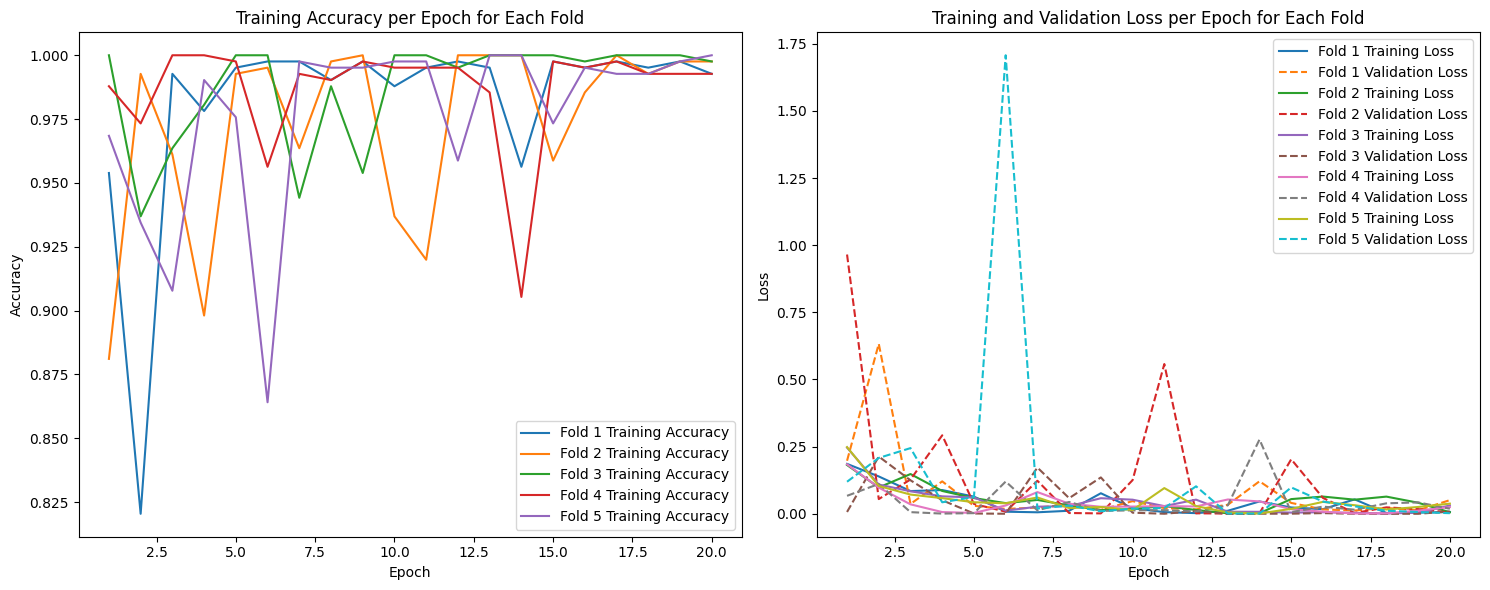

In [16]:
import matplotlib.pyplot as plt

# Assuming num_epochs is defined as 3 from your code snippet
epochs = range(1, num_epochs + 1)

# Create subplots: one for accuracy and one for loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loop over the all_fold_metrics list and plot accuracy and loss per fold
for i, fold_metrics in enumerate(all_fold_metrics):
    fold_idx = i + 1  # since enumeration in your loop starts from 1

    # Plot accuracy for this fold
    ax1.plot(epochs, fold_metrics['accuracy'], label=f'Fold {fold_idx} Training Accuracy')

    # Plot training and validation loss for this fold
    ax2.plot(epochs, fold_metrics['train_loss'], label=f'Fold {fold_idx} Training Loss')
    ax2.plot(epochs, fold_metrics['val_loss'], label=f'Fold {fold_idx} Validation Loss', linestyle='--')

# Set titles and labels for the accuracy plot
ax1.set_title('Training Accuracy per Epoch for Each Fold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Set titles and labels for the loss plot
ax2.set_title('Training and Validation Loss per Epoch for Each Fold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show plot with tight layout
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/papertaro/Resultados/InceptionV3/lossIV3_kfold_epochs.png")
plt.show()


##CM

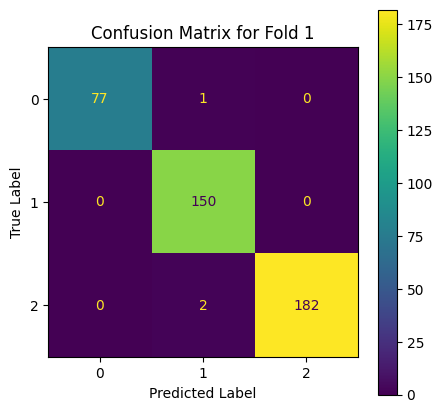

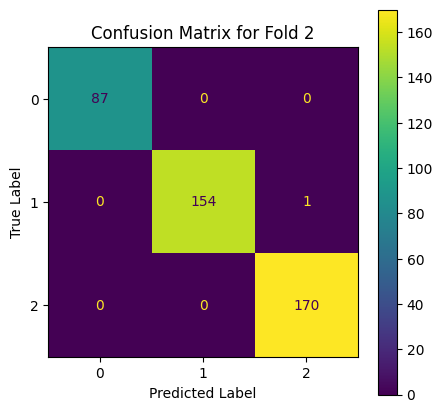

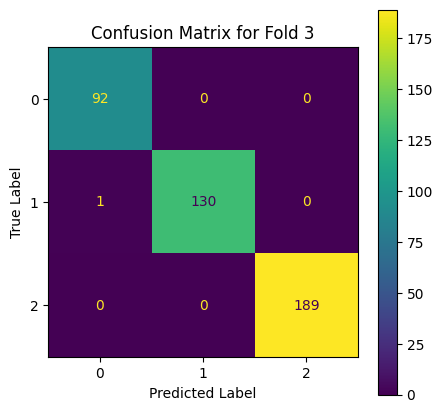

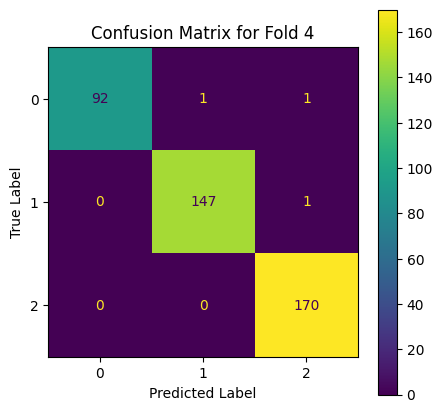

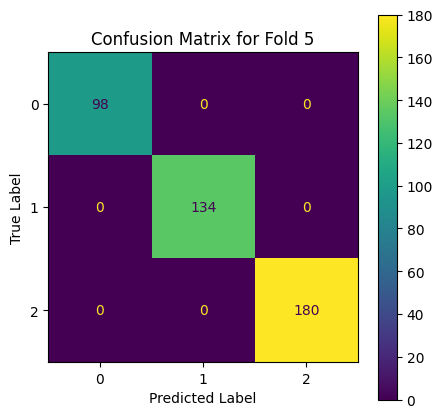

In [17]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_and_save_confusion_matrix(cm, fold_idx, save_path="confusion_matrices"):
    """
    Plots and saves the confusion matrix for a given fold.

    Parameters:
    - cm: The confusion matrix to plot.
    - fold_idx: The index of the current fold (for title and filename).
    - save_path: Base directory to save the plots.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {fold_idx}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    plt.savefig("/content/drive/MyDrive/papertaro/confusion_matrix.png")
    plt.show()

# Iterate over all_fold_metrics to plot and save each fold's confusion matrix
for idx, fold_metrics in enumerate(all_fold_metrics, start=1):
    cm = fold_metrics['confusion_matrix']
    plot_and_save_confusion_matrix(cm, idx)


In [18]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_and_save_confusion_matrix(cm, fold_idx, save_path):
    """
    Plots and saves the confusion matrix for a given fold.

    Parameters:
    - cm: The confusion matrix to plot.
    - fold_idx: The index of the current fold (for title and filename).
    - save_path: Base directory to save the plots.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {fold_idx}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    # Save each plot with a unique name using fold_idx
    filename = os.path.join(save_path, f'confusion_matrix_fold_{fold_idx}.png')
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free memory

# Base save path defined here
base_save_path = "/content/drive/MyDrive/papertaro/Resultados/InceptionV3/"

# Assume all_fold_metrics is defined somewhere in your code
# Iterate over all_fold_metrics to plot and save each fold's confusion matrix
for idx, fold_metrics in enumerate(all_fold_metrics, start=1):
    cm = fold_metrics['confusion_matrix']
    plot_and_save_confusion_matrix(cm, idx, base_save_path)


##ROCS

In [19]:
def plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes):
    n_folds = len(all_fold_metrics)
    plt.figure(figsize=(14, n_folds * 4))

    for fold_idx, metrics in enumerate(all_fold_metrics, 1):
        # Setup subplot for each fold
        ax = plt.subplot(n_folds, 1, fold_idx)

        # Plot micro-average ROC curve
        fpr_micro = metrics['fpr_micro'][-1]
        tpr_micro = metrics['tpr_micro'][-1]
        roc_auc_micro = metrics['roc_auc_micro'][-1]
        ax.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)

        # Plot macro-average ROC curve
        fpr_macro = metrics['fpr_macro'][-1]
        tpr_macro = metrics['tpr_macro'][-1]
        roc_auc_macro = metrics['roc_auc_macro'][-1]
        ax.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (area = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

        # Plot ROC curve for each class
        for i in range(num_classes):
            fpr_class = metrics[f'fpr_class_{i}'][-1]
            tpr_class = metrics[f'tpr_class_{i}'][-1]
            roc_auc_class = metrics[f'roc_auc_class_{i}'][-1]
            ax.plot(fpr_class, tpr_class, lw=2, label=f'Class {i} ROC curve (area = {roc_auc_class:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves for Fold {fold_idx}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


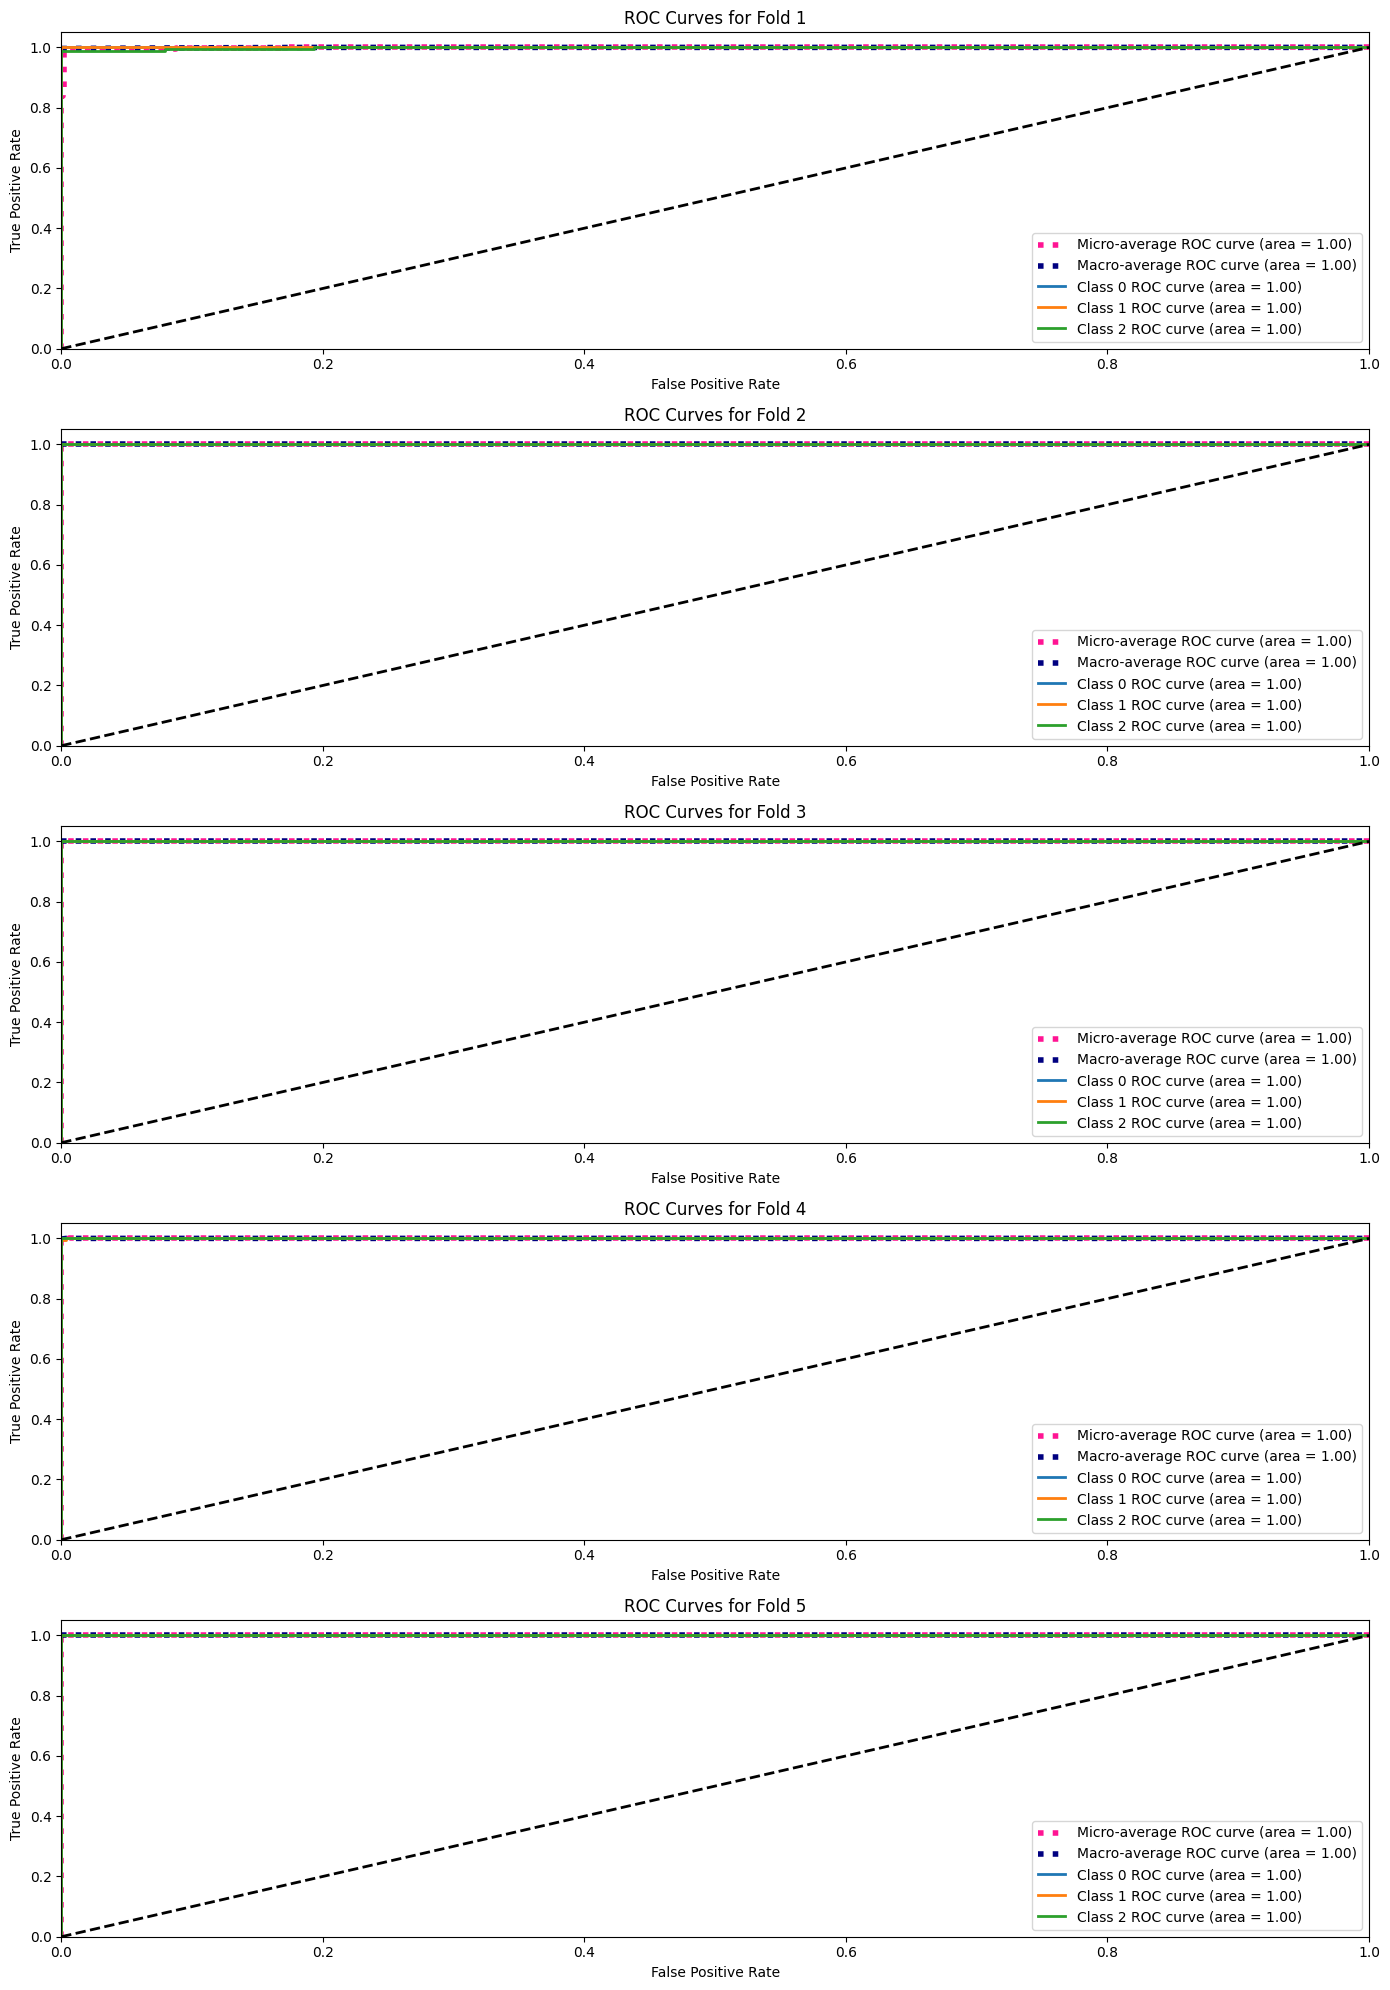

In [20]:
# Call the updated function with your all_fold_metrics and the number of classes
plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes=3)


In [21]:
import matplotlib.pyplot as plt

def plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes, save_path=None):
    n_folds = len(all_fold_metrics)
    plt.figure(figsize=(8, n_folds * 4))

    for fold_idx, metrics in enumerate(all_fold_metrics, 1):
        # Setup subplot for each fold
        ax = plt.subplot(n_folds, 1, fold_idx)

        # Plot micro-average ROC curve
        fpr_micro = metrics['fpr_micro'][-1]
        tpr_micro = metrics['tpr_micro'][-1]
        roc_auc_micro = metrics['roc_auc_micro'][-1]
        ax.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)

        # Plot macro-average ROC curve
        fpr_macro = metrics['fpr_macro'][-1]
        tpr_macro = metrics['tpr_macro'][-1]
        roc_auc_macro = metrics['roc_auc_macro'][-1]
        ax.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (area = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)

        # Plot ROC curve for each class
        for i in range(num_classes):
            fpr_class = metrics[f'fpr_class_{i}'][-1]
            tpr_class = metrics[f'tpr_class_{i}'][-1]
            roc_auc_class = metrics[f'roc_auc_class_{i}'][-1]
            ax.plot(fpr_class, tpr_class, lw=2, label=f'Class {i} ROC curve (area = {roc_auc_class:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves for Fold {fold_idx}')
        ax.legend(loc="lower right")

    plt.tight_layout()

    # Check if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the figure to the specified path with 300 dpi resolution
        print(f"Plot saved to {save_path}")
    else:
        plt.show()  # Show the plot as before if no save path is provided


In [22]:
save_path = '/content/drive/MyDrive/papertaro/Resultados/InceptionV3/roc_curves.png'


Plot saved to /content/drive/MyDrive/papertaro/Resultados/InceptionV3/roc_curves.png


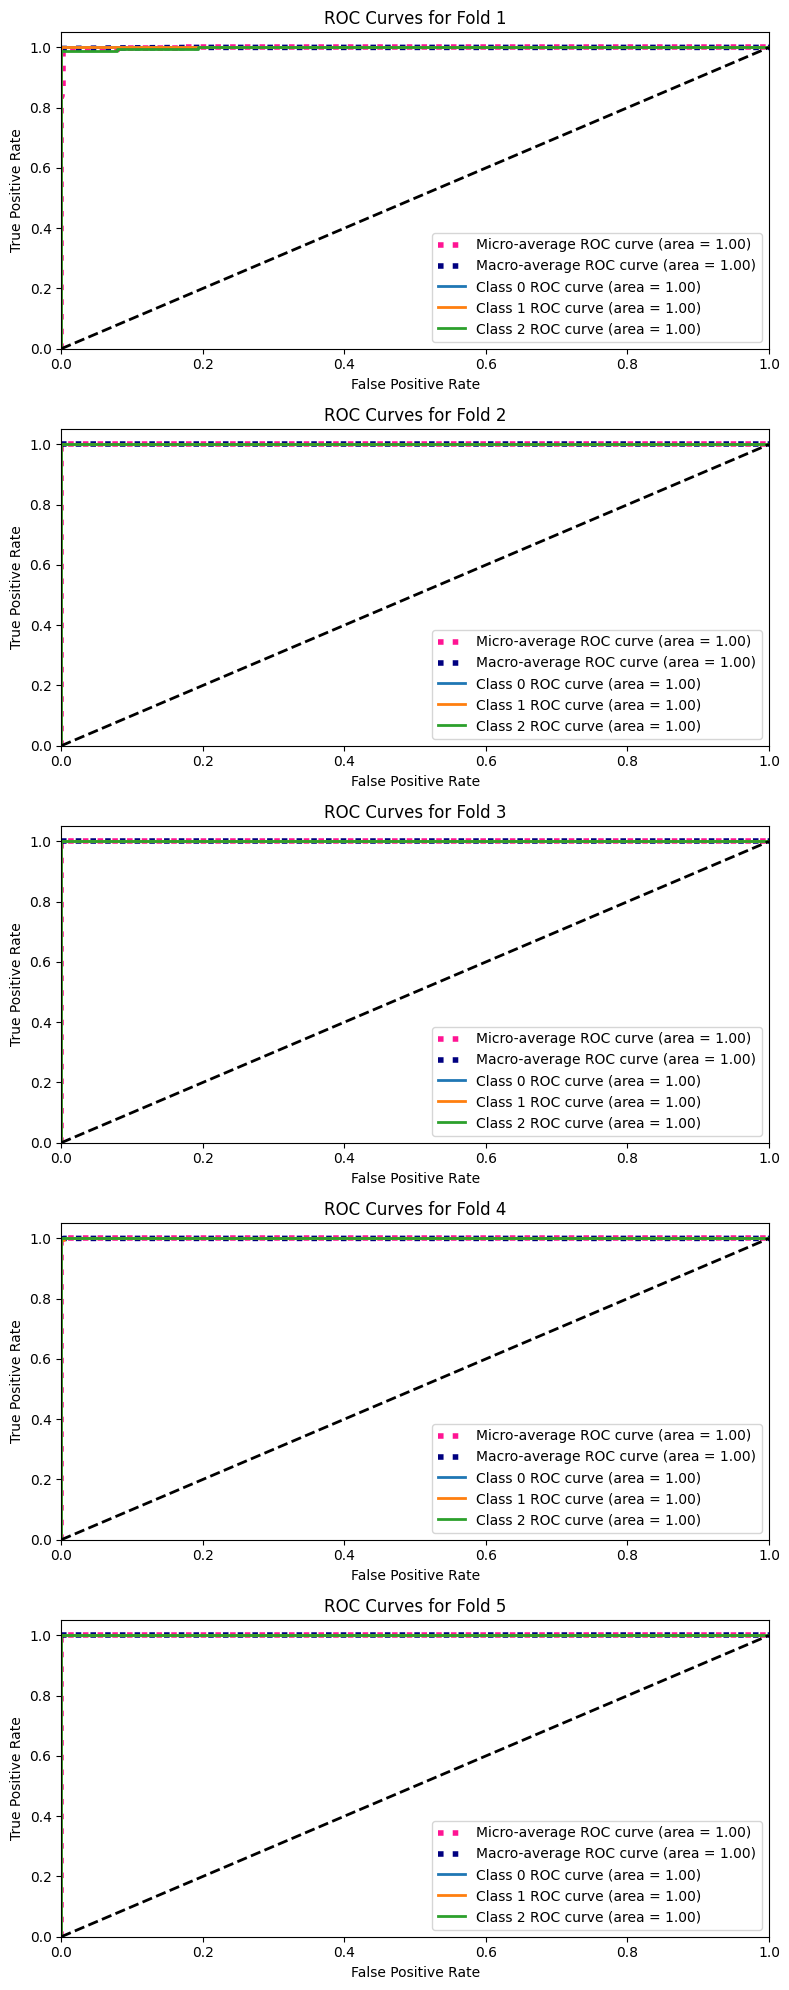

In [23]:
plot_roc_curves_for_all_folds_last_epoch(all_fold_metrics, num_classes, save_path=save_path)


#SHAPS

In [24]:
!pip install shap==0.45.0

import the best model from the k-folds

In [25]:
import shap
# Initialize the model architecture as per the last training configuration
num_classes = 3  # Replace with the actual number of classes you have
model = prepare_model(num_classes, pretrained=True)

# Load the trained model weights
model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))
model.eval()  # Set the model to evaluation mode




<ipython-input-25-c1a58bec5a0c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

<ipython-input-26-c74c420a9839>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))


Shape of SHAP values for class: (299, 299, 3)


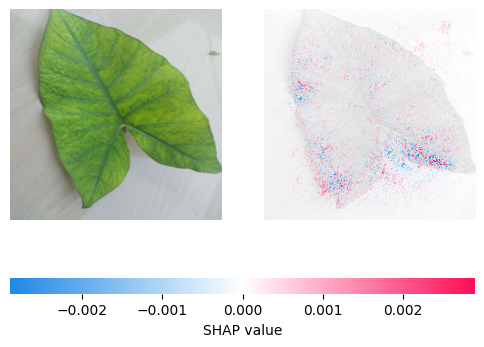

In [26]:

# Initialize the model architecture as per the last training configuration
num_classes = 3  # Replace with the actual number of classes you have
model = prepare_model(num_classes, pretrained=True)

# Load the trained model weights
model.load_state_dict(torch.load('best_model_fold_2.pth', map_location=device))
model.eval()  # Set the model to evaluation mode


import shap

# Free up memory if possible
torch.cuda.empty_cache()

# Select a representative background sample instead of the full dataset
background_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=100, shuffle=True)  # smaller batch size
background_data, _ = next(iter(background_loader))
background_data = background_data.to(device)

# Initialize SHAP using the smaller background sample
e = shap.GradientExplainer(model, background_data)

# Get a batch of test data
test_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=1, shuffle=True)  # single image batch
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Compute SHAP values for a single test image
shap_values = e.shap_values(test_images)

# Assuming `test_images` is a tensor of shape (N, C, H, W)

# Convert to numpy and adjust the dimensions to (N, H, W, C) for plotting
test_images_np = test_images.cpu().numpy().transpose(0, 2, 3, 1)

# Optionally, reverse the normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Apply the reverse normalization formula
test_images_np = std * test_images_np + mean
test_images_np = np.clip(test_images_np, 0, 1)  # Ensure the values are in the range [0,1]

# Compute predictions for the test images
output = model(test_images)

# Assuming output is the model prediction and shap_values has been computed
predicted_class = output.argmax(1).item()

# The SHAP values for the predicted class should be selected as follows
shap_values_for_class = shap_values[0][predicted_class]

# Confirm the shape of the SHAP values for the class
print('Shape of SHAP values for class:', shap_values_for_class.shape)

# Assuming test_images_np contains the denormalized images correctly shaped for plotting
test_image_for_plotting = test_images_np[0]

# Now let's plot the SHAP values with the denormalized image
shap.image_plot(shap_values_for_class, test_image_for_plotting)


In [27]:
save_dir = '/content/'  # Adjust the path as needed

In [28]:
import os

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


Class 0, Image 1:


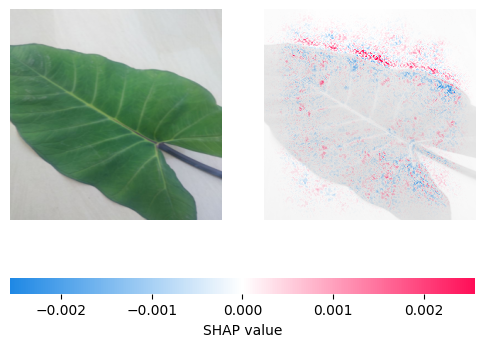

Class 0, Image 2:


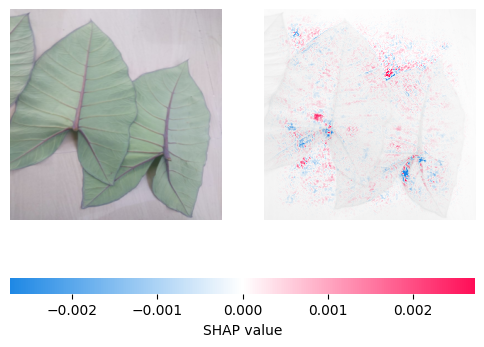

Class 0, Image 3:


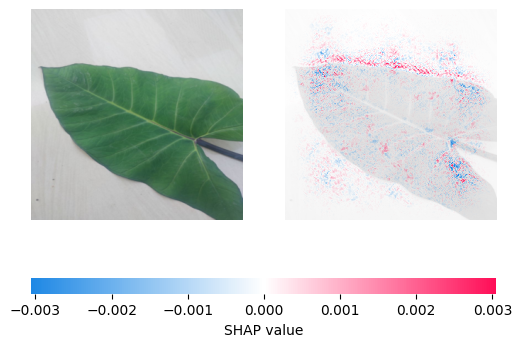

Class 0, Image 4:


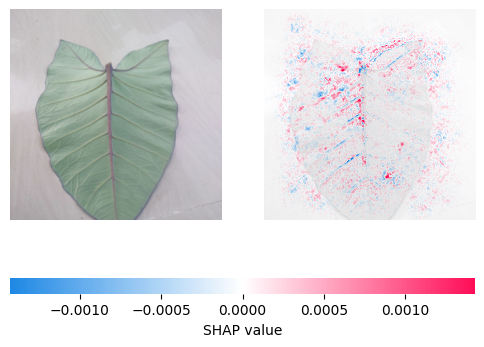

Class 0, Image 5:


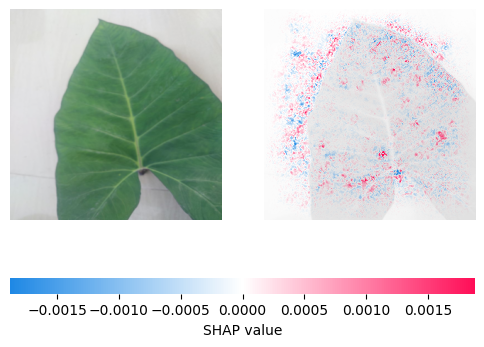

Class 0, Image 6:


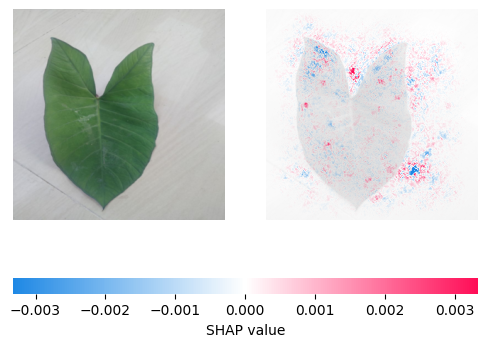

Class 0, Image 7:


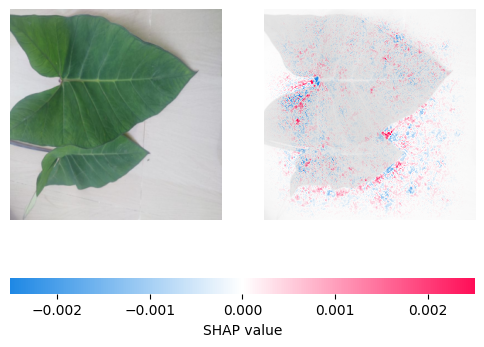

Class 0, Image 8:


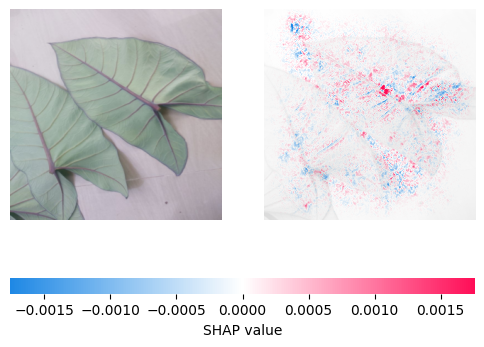

Class 0, Image 9:


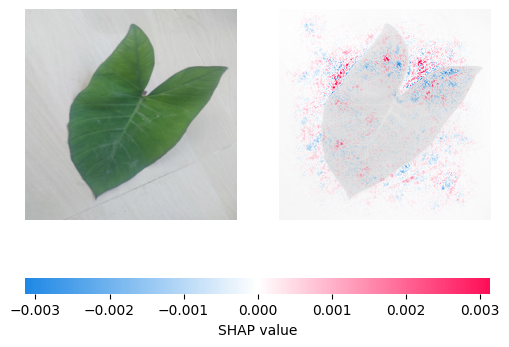

Class 0, Image 10:


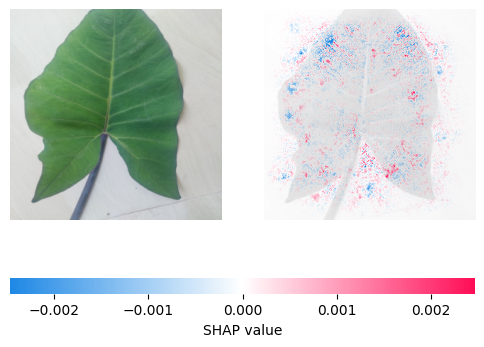

Class 1, Image 1:


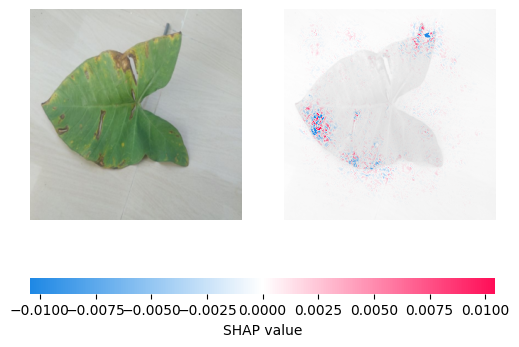

Class 1, Image 2:


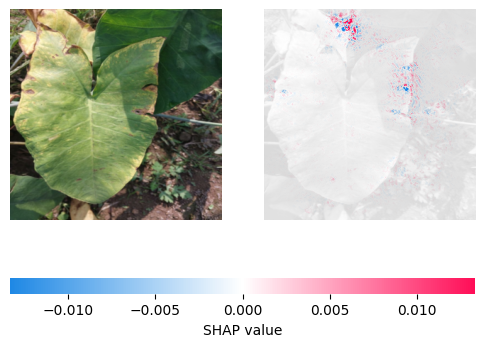

Class 1, Image 3:


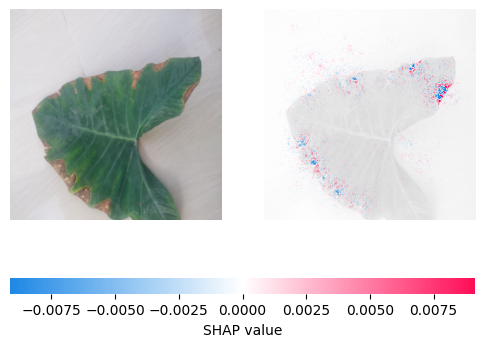

Class 1, Image 4:


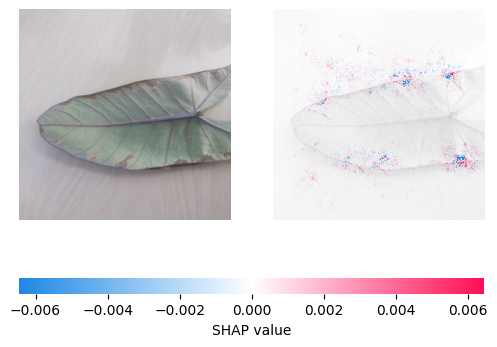

Class 1, Image 5:


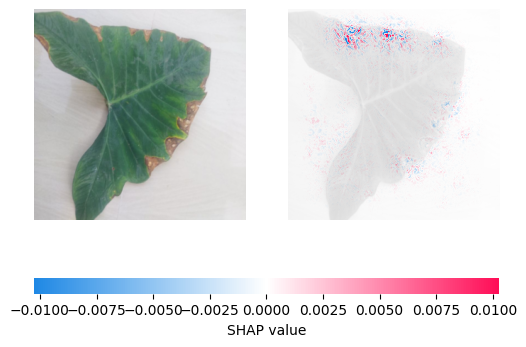

Class 1, Image 6:


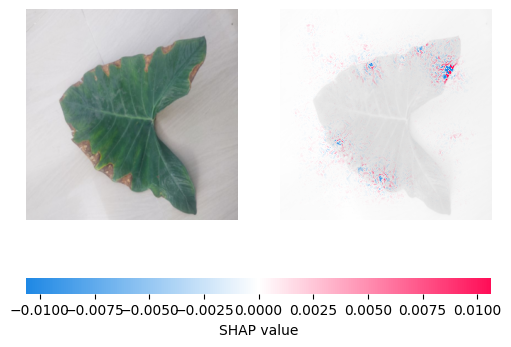

Class 1, Image 7:


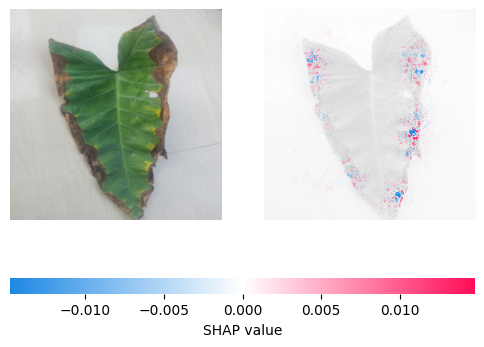

Class 1, Image 8:


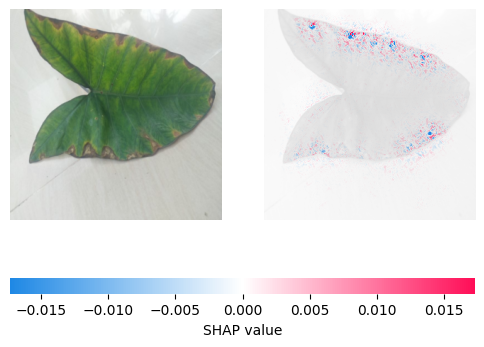

Class 1, Image 9:


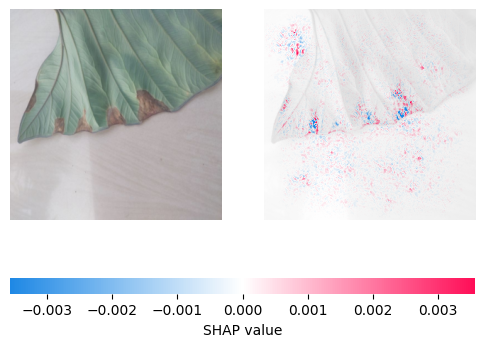

Class 1, Image 10:


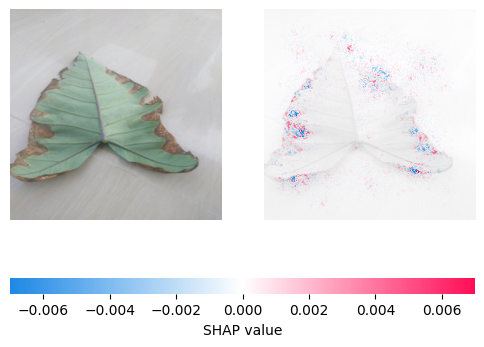

Class 2, Image 1:


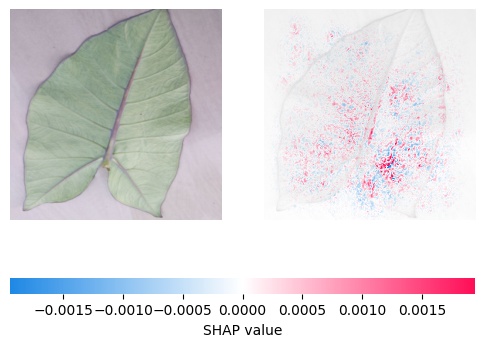

Class 2, Image 2:


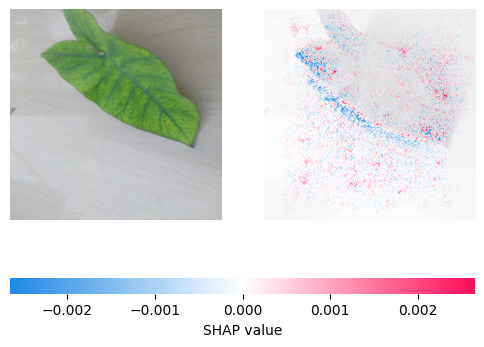

Class 2, Image 3:


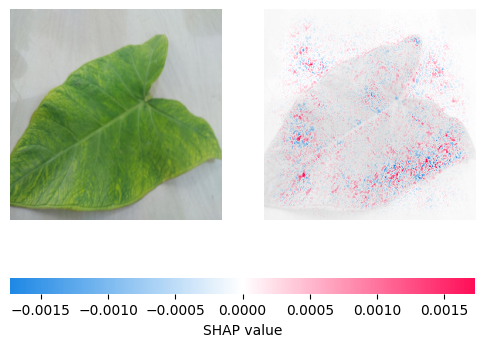

Class 2, Image 4:


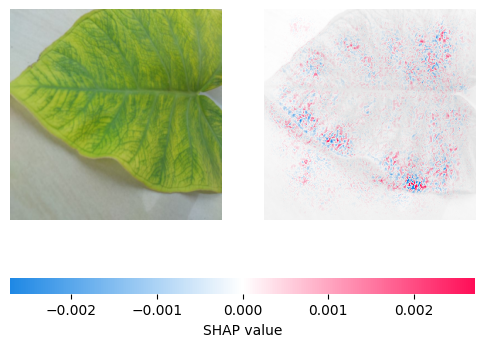

Class 2, Image 5:


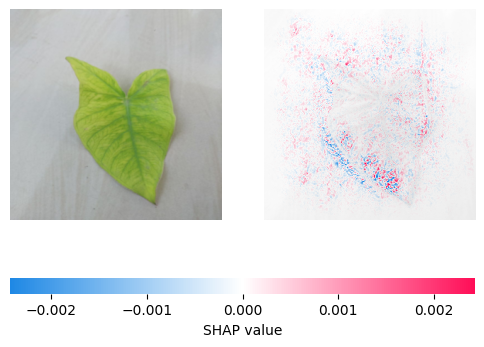

Class 2, Image 6:


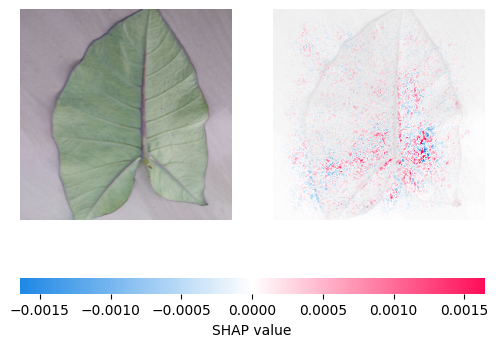

Class 2, Image 7:


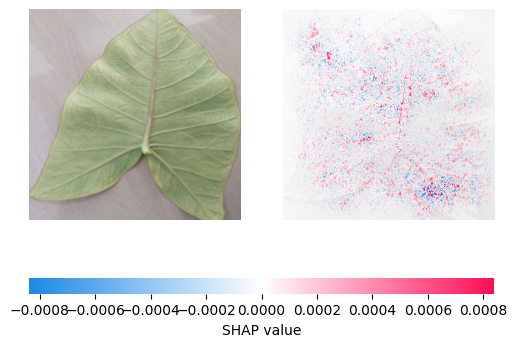

Class 2, Image 8:


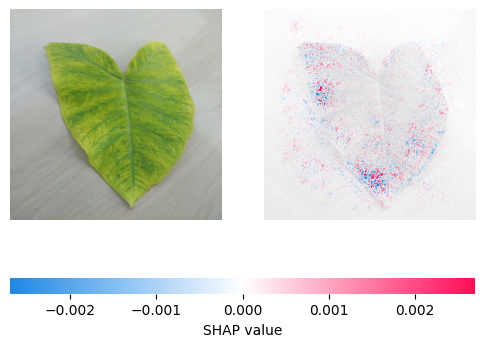

Class 2, Image 9:


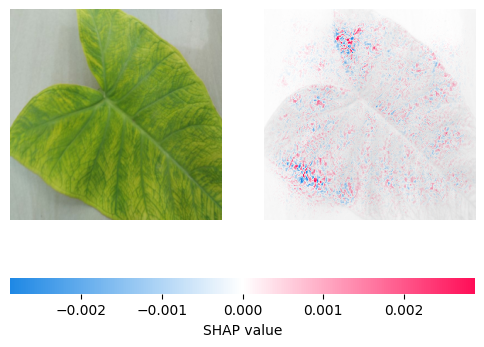

Class 2, Image 10:


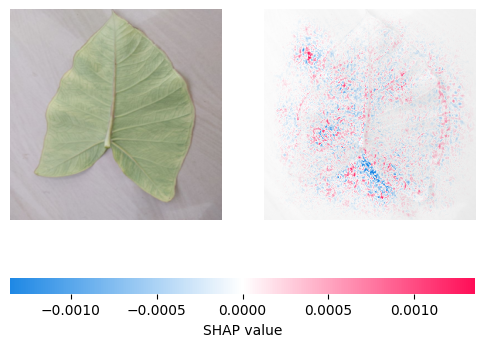

In [29]:
import shap
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np

# Free up memory if possible
torch.cuda.empty_cache()

# Parameters
num_classes = 3  # Adjust based on your model
num_images_per_class = 10  # Number of images you want to process for each class

# Select a representative background sample instead of the full dataset
background_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=100, shuffle=True)  # smaller batch size
background_data, _ = next(iter(background_loader))
background_data = background_data.to(device)

# Initialize SHAP using the smaller background sample
e = shap.GradientExplainer(model, background_data)

# Load all test data
test_loader = DataLoader(ImageFolder(root=directory, transform=transform), batch_size=1, shuffle=True)

images_per_class = {class_idx: [] for class_idx in range(num_classes)}  # Store test images by predicted class
shap_values_per_class = {class_idx: [] for class_idx in range(num_classes)}  # Store SHAP values by predicted class

for test_images, _ in test_loader:
    if all(len(images) >= num_images_per_class for images in images_per_class.values()):
        break  # Stop once we have enough images for each class

    test_images = test_images.to(device)

    # Compute predictions to determine the class
    output = model(test_images)
    predicted_class = output.argmax(1).item()

    if len(images_per_class[predicted_class]) < num_images_per_class:
        # Compute SHAP values for the predicted class
        shap_values = e.shap_values(test_images)
        shap_values_for_class = shap_values[0][predicted_class]

        # Store image and its SHAP values
        images_per_class[predicted_class].append(test_images)
        shap_values_per_class[predicted_class].append(shap_values_for_class)

# Optionally, reverse the normalization for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Reverse normalization
        test_image = np.clip(test_image, 0, 1)  # Ensure the values are in the range [0,1]

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]

        # Plot the SHAP values with the denormalized image
        print(f"Class {class_idx}, Image {image_idx+1}:")
        shap.image_plot(shap_values_for_plotting, test_image[0])  # Adjust if necessary for correct plotting


In [37]:
9

9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Configuración inicial del archivo PDF
pdf_path = "shap_visualizations_RGB.pdf"
pdf = PdfPages(pdf_path)

# Supongamos que ya tienes `shap_values_per_class` y `images_per_class`
# num_classes: número de clases
# num_images_per_class: número de imágenes por clase
for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (H, W, C)

        # Asegúrate que shap_values_for_plotting sea (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        channel_names = ["R", "G", "B"]
        for c, channel_name in enumerate(channel_names):
            single_channel_shap = np.zeros_like(shap_values_for_plotting)
            single_channel_shap[:, :, c] = shap_values_for_plotting[:, :, c]

            # Crear una figura para la visualización
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))

            # Mostrar la imagen original
            ax[0].imshow(test_image[0])
            ax[0].set_title(f"Original Image (Class {class_idx})")
            ax[0].axis("off")

            # Mostrar el canal específico del SHAP
            ax[1].imshow(single_channel_shap[:, :, c], cmap="coolwarm")
            ax[1].set_title(f"SHAP - Channel: {channel_name}")
            ax[1].axis("off")

            # Agregar la figura al PDF
            pdf.savefig(fig)
            plt.close(fig)

# Cerrar el archivo PDF
pdf.close()

print(f"Las visualizaciones se han guardado en {pdf_path}.")


In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
from matplotlib.backends.backend_pdf import PdfPages

pdf_path = "shap_values_visualizations.pdf"
pdf = PdfPages(pdf_path)

channel_names = ["R", "G", "B"]

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        # Preparar la imagen
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (H, W, C)

        # Asegurar la forma (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        # Generar una página en el PDF por canal
        for c, channel_name in enumerate(channel_names):
            single_channel_shap = np.zeros_like(shap_values_for_plotting)
            single_channel_shap[:, :, c] = shap_values_for_plotting[:, :, c]

            fig_title = f"Class {class_idx}, Image {image_idx+1}, Channel: {channel_name}"
            print(fig_title)

            # Crear una nueva figura
            plt.figure()
            shap.image_plot(single_channel_shap[None], test_image[0][None])
            # Añadir título a la figura
            plt.title(fig_title)

            # Guardar la figura actual en el PDF
            pdf.savefig(plt.gcf())
            plt.close()

# Cerrar el archivo PDF
pdf.close()

print(f"Las visualizaciones se han guardado en {pdf_path}.")


Class 0, Image 1, Channel: R
Class 0, Image 1, Channel: G
Class 0, Image 1, Channel: B
Class 0, Image 2, Channel: R
Class 0, Image 2, Channel: G
Class 0, Image 2, Channel: B
Class 0, Image 3, Channel: R
Class 0, Image 3, Channel: G
Class 0, Image 3, Channel: B
Class 0, Image 4, Channel: R
Class 0, Image 4, Channel: G
Class 0, Image 4, Channel: B
Class 0, Image 5, Channel: R
Class 0, Image 5, Channel: G
Class 0, Image 5, Channel: B
Class 0, Image 6, Channel: R
Class 0, Image 6, Channel: G
Class 0, Image 6, Channel: B
Class 0, Image 7, Channel: R
Class 0, Image 7, Channel: G
Class 0, Image 7, Channel: B
Class 0, Image 8, Channel: R
Class 0, Image 8, Channel: G
Class 0, Image 8, Channel: B
Class 0, Image 9, Channel: R
Class 0, Image 9, Channel: G
Class 0, Image 9, Channel: B
Class 0, Image 10, Channel: R
Class 0, Image 10, Channel: G
Class 0, Image 10, Channel: B
Class 1, Image 1, Channel: R
Class 1, Image 1, Channel: G
Class 1, Image 1, Channel: B
Class 1, Image 2, Channel: R
Class 1, Im

In [38]:
import numpy as np

# Supongamos que ya tienes shap_values_for_plotting (H, W, C) y test_image (H, W, C)
# shap_values_for_plotting: matriz de SHAP con 3 canales (R, G, B)
# test_image[0]: imagen de entrada con la misma forma (H, W, C)

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (H, W, C)

        # Asegúrate que shap_values_for_plotting sea (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            # Si está en formato (C, H, W), transpón a (H, W, C)
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        channel_names = ["R", "G", "B"]
        for c, channel_name in enumerate(channel_names):
            single_channel_shap = np.zeros_like(shap_values_for_plotting)
            single_channel_shap[:, :, c] = shap_values_for_plotting[:, :, c]

            print(f"Class {class_idx}, Image {image_idx+1}, Channel: {channel_name}")

            # Añade la dimensión extra con [None] para que tenga la forma (1, H, W, C)
            shap.image_plot(single_channel_shap[None], test_image[0][None])



Class 0, Image 1, Channel: R
Class 0, Image 1, Channel: G
Class 0, Image 1, Channel: B
Class 0, Image 2, Channel: R
Class 0, Image 2, Channel: G
Class 0, Image 2, Channel: B
Class 0, Image 3, Channel: R
Class 0, Image 3, Channel: G
Class 0, Image 3, Channel: B
Class 0, Image 4, Channel: R
Class 0, Image 4, Channel: G
Class 0, Image 4, Channel: B
Class 0, Image 5, Channel: R
Class 0, Image 5, Channel: G
Class 0, Image 5, Channel: B
Class 0, Image 6, Channel: R
Class 0, Image 6, Channel: G
Class 0, Image 6, Channel: B
Class 0, Image 7, Channel: R
Class 0, Image 7, Channel: G
Class 0, Image 7, Channel: B
Class 0, Image 8, Channel: R
Class 0, Image 8, Channel: G
Class 0, Image 8, Channel: B
Class 0, Image 9, Channel: R
Class 0, Image 9, Channel: G
Class 0, Image 9, Channel: B
Class 0, Image 10, Channel: R
Class 0, Image 10, Channel: G
Class 0, Image 10, Channel: B
Class 1, Image 1, Channel: R
Class 1, Image 1, Channel: G
Class 1, Image 1, Channel: B
Class 1, Image 2, Channel: R
Class 1, Im

In [39]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
channel_names = ["R", "G", "B"]

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar
        test_image = np.clip(test_image, 0, 1)
        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (C, H, W) o (H, W, C)

        # Asegúrate que los shap_values estén en (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            # Transponer de (C, H, W) a (H, W, C)
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        # Calcula la magnitud absoluta de los SHAP values
        abs_shap_values = np.abs(shap_values_for_plotting)

        # Promedio por canal: primero sumamos sobre la dimensión espacial (H, W), luego promediamos
        mean_abs_shap_per_channel = abs_shap_values.mean(axis=(0,1))  # (C,)

        # Graficar
        plt.figure(figsize=(4,4))
        plt.bar(channel_names, mean_abs_shap_per_channel, color=["red","green","blue"])
        plt.title(f"Class {class_idx}, Image {image_idx+1}\nMean Abs SHAP by Channel")
        plt.ylabel("Mean Absolute SHAP Value")
        plt.xlabel("Channel")
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
channel_names = ["R", "G", "B"]

# Lista para almacenar [class_idx, image_idx, mean_abs_shap_R, mean_abs_shap_G, mean_abs_shap_B]
data_for_heatmap = []

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar (opcional)
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (C, H, W) o (H, W, C)

        # Asegurarse que shap_values_for_plotting esté en (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        abs_shap_values = np.abs(shap_values_for_plotting)
        mean_abs_shap_per_channel = abs_shap_values.mean(axis=(0,1))  # (R, G, B)

        # Almacenar la información
        data_for_heatmap.append([class_idx, image_idx] + mean_abs_shap_per_channel.tolist())

# Convertir la lista en un arreglo numpy
data_for_heatmap = np.array(data_for_heatmap)
# data_for_heatmap tiene la forma (num_clases * num_imagenes, 2 + 3)
# Columnas: [class_idx, image_idx, mean_R, mean_G, mean_B]

# Ordenar por clase (opcional)
sorted_indices = np.lexsort((data_for_heatmap[:,1], data_for_heatmap[:,0]))
data_for_heatmap = data_for_heatmap[sorted_indices]

# Extraer solo las columnas de SHAP (R, G, B)
shap_matrix = data_for_heatmap[:, 2:]  # (num_clases * num_imagenes, 3)

# Crear etiquetas para las filas que indiquen la clase y la imagen
row_labels = [f"Class{int(c)}_Img{int(i)}" for c,i in data_for_heatmap[:, :2]]

plt.figure(figsize=(8, max(2, len(row_labels)*0.4)))
sns.heatmap(shap_matrix, annot=True, fmt=".2f", yticklabels=row_labels, xticklabels=channel_names, cmap="coolwarm")
plt.title("Mean Absolute SHAP by Channel - Organized by Class and Image")
plt.xlabel("Channel")
plt.ylabel("Image (Class_Image)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
channel_names = ["R", "G", "B"]

data_for_heatmap = []

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Des-normalizar (opcional)
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]  # (C, H, W) o (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        abs_shap_values = np.abs(shap_values_for_plotting)
        mean_abs_shap_per_channel = abs_shap_values.mean(axis=(0,1))  # (R, G, B)

        data_for_heatmap.append([class_idx, image_idx] + mean_abs_shap_per_channel.tolist())

# Convertir a numpy array
data_for_heatmap = np.array(data_for_heatmap)
# Ordenar por clase e imagen
sorted_indices = np.lexsort((data_for_heatmap[:,1], data_for_heatmap[:,0]))
data_for_heatmap = data_for_heatmap[sorted_indices]

# Extraer sólo las columnas de SHAP (R, G, B)
shap_matrix = data_for_heatmap[:, 2:]  # (num_clases * num_imagenes, 3)

# Etiquetas para filas
row_labels = [f"C{int(c)}_I{int(i)}" for c,i in data_for_heatmap[:, :2]]

# Crear un Cluster Map
# metric y method se pueden ajustar (por defecto: Euclidean linkage)
# Puedes cambiar method por 'ward', 'single', 'complete' o 'average' según tus necesidades.
g = sns.clustermap(shap_matrix,
                   row_cluster=True,
                   col_cluster=True,
                   metric='euclidean',
                   method='average',
                   cmap="coolwarm",
                   annot=True,
                   fmt=".2f",
                   yticklabels=row_labels,
                   xticklabels=channel_names)

g.ax_heatmap.set_title("Clustermap of Mean Absolute SHAP by Channel")
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)  # Texto más legible
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
channel_names = ["R", "G", "B"]

data_for_heatmap = []

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean
        test_image = np.clip(test_image, 0, 1)

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]

        # Asegurarse de tener (H, W, C)
        if shap_values_for_plotting.shape[0] == 3:
            shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)

        abs_shap_values = np.abs(shap_values_for_plotting)
        mean_abs_shap_per_channel = abs_shap_values.mean(axis=(0,1))  # (R, G, B)

        data_for_heatmap.append([class_idx, image_idx] + mean_abs_shap_per_channel.tolist())

data_for_heatmap = np.array(data_for_heatmap)
sorted_indices = np.lexsort((data_for_heatmap[:,1], data_for_heatmap[:,0]))
data_for_heatmap = data_for_heatmap[sorted_indices]

shap_matrix = data_for_heatmap[:, 2:]
row_labels = [f"C{int(c)}_I{int(i)}" for c,i in data_for_heatmap[:, :2]]

# Asignar un color para cada clase
# Por ejemplo, usar una paleta de Seaborn distinta para las clases.
class_colors = sns.color_palette("Set2", num_classes)

# Crear una lista de colores en el orden de las filas
row_colors = [class_colors[int(c)] for c,i in data_for_heatmap[:, :2]]

# Crear el cluster map con row_colors
g = sns.clustermap(
    shap_matrix,
    row_cluster=True,
    col_cluster=True,
    metric='euclidean',
    method='average',
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    yticklabels=row_labels,
    xticklabels=channel_names,
    row_colors=row_colors
)

g.ax_heatmap.set_title("Clustermap of Mean Absolute SHAP by Channel with Class Colors")
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()


##PARA GUARDAR LAS IMAGENES DE LOS SHAPS

In [ ]:
import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend for saving figures
import matplotlib.pyplot as plt

for class_idx in range(num_classes):
    for image_idx in range(num_images_per_class):
        test_image = images_per_class[class_idx][image_idx].cpu().numpy().transpose(0, 2, 3, 1)
        test_image = std * test_image + mean  # Reverse normalization
        test_image = np.clip(test_image, 0, 1)  # Ensure the values are in the range [0,1]

        shap_values_for_plotting = shap_values_per_class[class_idx][image_idx]

         # Create a figure for plotting
        plt.figure(figsize=(20, 10))
        shap.image_plot(shap_values_for_plotting, test_image[0])

        # Define the save path for each image
        image_save_path = os.path.join(save_dir, f'class_{class_idx}_image_{image_idx+1}.png')

        # Save the figure with high resolution
        plt.savefig(image_save_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

#intento shaps